In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=0
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606886386871338

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = 'meta-llama/Meta-Llama-3.1-8B'
MODEL_SEQLEN = 8192

model_pt = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cpu',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path=MODEL_PATH,
    model_seqlen=MODEL_SEQLEN,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [6]:
import torch
from hqq.core.quantize import Quantizer as HqqQuantizer

@torch.no_grad()
def quantize_dequantize_hqq(weight, bits, group_size=64):    
    return HqqQuantizer.dequantize(*HqqQuantizer.quantize(
        weight,
        nbits=bits, group_size=group_size,
    ))


In [7]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [8]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [9]:
# data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
data_df = pd.read_csv('layerwise_slopes.csv')

data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

from sklearn.linear_model import LinearRegression

layers = sorted(set(data_df['layer']))

scale_by_layer = {}
intercept_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    # to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
    
    scale_by_layer[layer] = slope.item()
    intercept_by_layer[layer] = BASE_PPL

/tmp/ipykernel_2101340/3113886370.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('layerwise_slopes.csv')


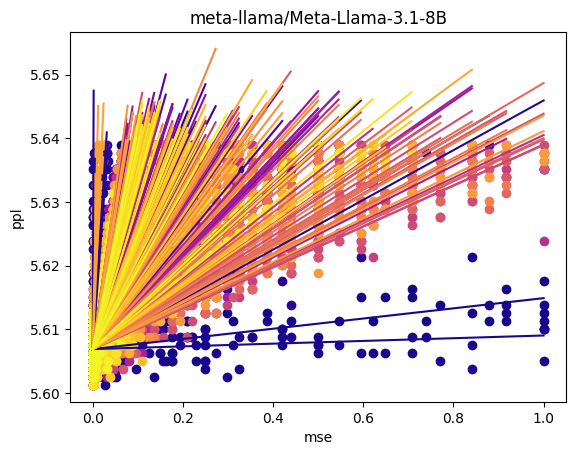

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

plt.scatter([0.0], [5.606692790985107])

for layer_idx, layer in enumerate(layers):
# for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer'] == layer]
    # to_plot = to_plot[to_plot['mse'] < 0.01]
    to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(0, to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercept_by_layer[layer] + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [11]:
from ortools.linear_solver import pywraplp

def find_grids_with_budget(
    slopes,    # linear coefficients for [layerwise mse -> metric]
    weights,   # linear coefficients for [layer bitwidth -> total bitwidth] (1 / num_blocks for blockwise)
    budget,    # upper bound on total bitwidth
    grid_bits, # available grid bitwidths
    grid_mses  # available grid mses
) -> tuple[float, list]:
    num_layers = len(slopes)
    num_grids = len(grid_bits)
    assert len(grid_mses) == num_grids
    
    solver = pywraplp.Solver.CreateSolver("CP-SAT")

    x = {(j, i) : solver.BoolVar("name") for i in range(num_grids) for j in range(num_layers)}
    
    for j in range(num_layers) : solver.Add(sum(x[(j, i)] for i in range(num_grids)) == 1)
    solver.Add(sum(x[(j, i)] * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids)) <= budget)
    solver.Minimize(sum(x[(j, i)] * slopes[j] * grid_mses[i] for j in range(num_layers) for i in range(num_grids)))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        avg_bits = sum(x[(j, i)].solution_value() * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids))
        solution = np.asarray([[x[(j, i)].solution_value() for i in range(num_grids)] for j in range(num_layers)])
        indices = np.argwhere(solution == 1.0)
        assert len(indices) == num_layers
        return avg_bits, indices[:,1]
    else:
        raise Exception("Didn't solve")

In [12]:
test_input = torch.randn((1024, 1024), device='cuda')

ok_grids = pd.DataFrame([{
    'name': 'fp16',
    'bits': 16,
    'mse': 0.0, # should be zero, but it breaks solver
}] + [{
    'name': f'hqq-{bits}',
    'bits': bits,
    'mse': (((quantize_dequantize_hqq(test_input, bits) - test_input).norm() ** 2) / (test_input.norm() ** 2)).item(),
} for bits in [8, 4, 3, 2, 1]])

ok_grids

,name,bits,mse
0,fp16,16,0.000000
1,hqq-8,8,0.000028
2,hqq-4,4,0.008036
3,hqq-3,3,0.036940
4,hqq-2,2,0.202741
5,hqq-1,1,2.736705


In [13]:
layers = sorted(layers)

scales = [scale_by_layer[layer] for layer in layers]
numels = [get_numel(layer) for layer in layers]
grid_names=ok_grids['name'].values
grid_bits=ok_grids['bits'].values
grid_mses=ok_grids['mse'].values

solution_size, solution_idxs = find_grids_with_budget(
    scales,
    numels,
    budget=sum(numels) * 8,
    grid_bits=ok_grids['bits'].values,
    grid_mses=ok_grids['mse'].values,
)

print(f'{solution_size / sum(numels)} bits')

8.0 bits


In [14]:
def get_solution(n_bits = 8):
    scales = [scale_by_layer[layer] for layer in layers]
    numels = [get_numel(layer) for layer in layers]
    grid_names=ok_grids['name'].values
    grid_bits=ok_grids['bits'].values
    grid_mses=ok_grids['mse'].values
    
    solution_size, solution_idxs = find_grids_with_budget(
        scales,
        numels,
        budget=sum(numels) * n_bits,
        grid_bits=ok_grids['bits'].values,
        grid_mses=ok_grids['mse'].values,
    )

    solution_pred_err = sum([scale * ok_grids['mse'].values[solution_idx] for solution_idx, scale in zip(solution_idxs, scales)])

    return solution_size, solution_pred_err, solution_idxs

In [15]:
grid = np.linspace(2.0, 8.0, num=40)

hqq_pred_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    hqq_pred_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
    })

hqq_pred_df = pd.DataFrame(hqq_pred_lines)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


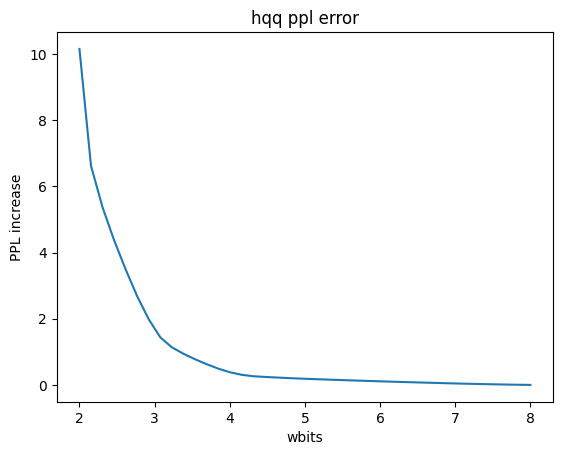

In [16]:
plt.title('hqq ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(hqq_pred_df['solution_size'] / total_params, hqq_pred_df['solution_pred_err'])

plt.show()

In [17]:
def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

In [18]:
model_pt = model_pt.cuda()

In [19]:
BASELINE_PPL = eval_ppl(model_pt)['wikitext2']
BASELINE_PPL

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


5.606260776519775

In [20]:
model_state_dict = model_pt.state_dict()

In [21]:
layer_names = [f"model.layers.{i}.self_attn.{name}_proj" for i in range(32) for name in ("q","k","v","o")] + \
    [f"model.layers.{i}.mlp.{name}_proj" for i in range(32) for name in ("gate","up","down")]

In [22]:
state_dicts = {
    "fp16": {name[:-7]: val for name, val in model_state_dict.items*()}
} | {
    f"hqq-{bits}": {layer: quantize_dequantize_hqq(model_state_dict[f'{layer}.weight'], bits) for layer in tqdm.tqdm(layer_names)} for bits in [8, 4, 3, 2, 1]
}

100%|██████████| 224/224 [00:48<00:00,  4.66it/s]


In [28]:
import tqdm
import copy

@torch.no_grad()
def eval_quantized_model(solution_idxs):
    quantized_model = copy.deepcopy(model_pt)
    
    for layer_name, quant_idx in zip(layers, solution_idxs):
        layer = get_module_by_path(quantized_model, layer_name)
        weight = state_dicts[grid_names[quant_idx]][layer_name].clone().detach()
        layer.weight.data = weight.to(torch.bfloat16)
        # print(layer, quant_idx)

    return eval_ppl(quantized_model)['wikitext2'] - BASELINE_PPL


In [34]:
grid = np.linspace(2.0, 8.0, num=40)

hqq_real_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    real_err = eval_quantized_model(solution_idxs)
    hqq_real_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
        'solution_real_err': real_err,
    })

100%|██████████| 1/1 [00:59<00:00, 59.74s/it]


In [35]:
hqq_real_df = pd.DataFrame(hqq_real_lines)

In [36]:
hqq_real_df['solution_size'] / total_params

0     1.999925
1     2.153765
2     2.307606
3     2.461446
4     2.615286
5     2.769127
6     2.922967
7     3.076808
8     3.230648
9     3.384488
10    3.538329
11    3.692169
12    3.846009
13    3.999850
14    4.153690
15    4.307531
16    4.461371
17    4.614610
18    4.769052
19    4.922892
20    5.076732
21    5.230573
22    5.384413
23    5.538254
24    5.692094
25    5.845934
26    5.999775
27    6.153615
28    6.307455
29    6.461296
30    6.615136
31    6.768977
32    6.922817
33    7.076657
34    7.230498
35    7.384338
36    7.538178
37    7.692019
38    7.843455
39    7.999700
Name: solution_size, dtype: float64

Text(0, 0.5, 'real ppl err')

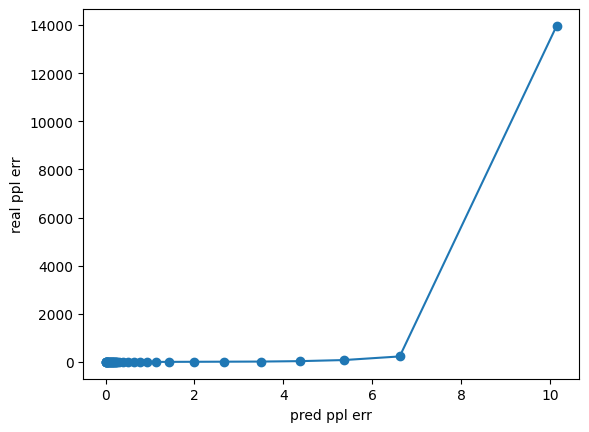

In [37]:
plt.scatter(hqq_real_df['solution_pred_err'], hqq_real_df['solution_real_err'])
plt.plot(hqq_real_df['solution_pred_err'], hqq_real_df['solution_real_err'])
plt.xlabel('pred ppl err')
plt.ylabel('real ppl err')

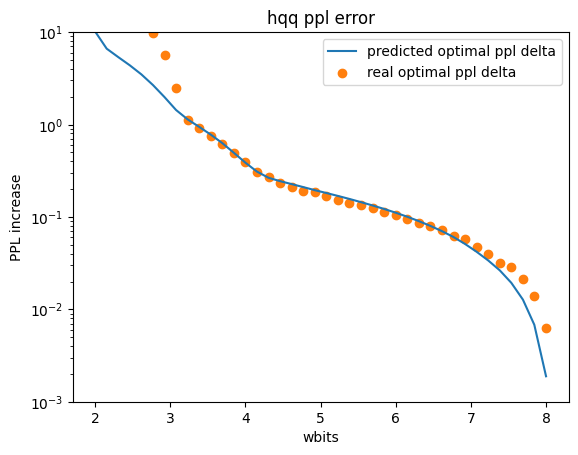

In [39]:
import matplotlib as mpl

plt.title('hqq ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(hqq_pred_df['solution_size'] / total_params, hqq_pred_df['solution_pred_err'], label='predicted optimal ppl delta')
plt.scatter(hqq_real_df['solution_size'] / total_params, hqq_real_df['solution_real_err'], color=mpl.colormaps['tab10'](1), label='real optimal ppl delta')
plt.ylim(1e-3, 10)
plt.yscale("log")

plt.legend()

plt.show()

In [40]:
hqq_pred_df.to_csv('layerwise_hqq_pred_df.csv')
hqq_real_df.to_csv('layerwise_hqq_real_df.csv')